In [1]:
import numpy as np
import time
from scipy import misc
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.use('Qt5Agg')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
#import cvxpy as cp
from scipy.optimize import fsolve
torch.set_default_dtype(torch.float64)

# Parameters of the model

In [2]:
M=1000
ite=10
dim_n=3
T=1
delta = torch.tensor(T/ite)
#delta=torch.tensor(0.01)
sigma=0.2
mu=0.3
A0=0.0
gamma=0.0
kappa=1
rho=5
X0=10000
neuron_model_psi=16
print(delta)

tensor(0.1000)


In [3]:
params = {'M':1000,
        'num_time_steps':10,
        'dim':3, #dimension
        'T':1,# terminal time
        'sigma':0.2,
        'mu':0.3,
        'A0':0.0, #initial fundamental price
        'gamma':0.0, # permanent price impact
        'kappa':1,#price impact coeff
        'rho':5,#resillience
        'init_balance':10000,
        'num_neurons':16}
delta = torch.tensor(T/ite)

# Colsed-form solution


In [4]:
def closed_form(X):
  alpa=np.exp(-rho*T/ite)
  p=np.zeros(ite+1)
  p[0]=X/((ite-1)*(1-alpa)+2)
  p[ite]=X/((ite-1)*(1-alpa)+2)
  for j in range(1,ite):
    p[j]=p[0]*(1-alpa)
  return p


In [5]:
class solution(object):
    def __init__(self,params):
        self.ite = params['num_time_steps']
        self.T = params['T']
        self.rho = params['rho']
        self.kappa = params['kappa']
        self.delta = self.T/self.ite
        self.alpha=np.exp(-self.rho*self.delta)
    def optimal(self,x_init):
        x = torch.tensor([[i*self.delta,x_init] for i in range(ite+1)])
        return ((1-(torch.where(x[:,0]==0.0*self.delta,0,1)*torch.where(x[:,0]==self.ite*self.delta,0,1))*self.alpha)*x[:,1]/((self.ite-1)*(1-self.alpha)+2)).unsqueeze(0) 
    def __call__(self, x):
        exec =  self.optimal(x)   
        c_tmp = torch.tensor([0.0])
        D_tmp = torch.tensor([0.0])
        for i in range(ite+1):
            c_tmp = c_tmp + D_tmp*exec[:,i]+(self.kappa/2.0)*np.power(exec[:,i],2)
            D_tmp = (D_tmp + self.kappa * exec[:,i])*self.alpha
        return c_tmp,exec # 

In [6]:
cf = solution(params)


In [7]:
x0 = 10000.0

In [8]:
closed_form_loss , exec = cf(x0)
print("{:.10E}".format(closed_form_loss[0]))
print(exec)

1.4496171257E+07
tensor([[1804.6554,  710.0766,  710.0766,  710.0766,  710.0766,  710.0766,
          710.0766,  710.0766,  710.0766,  710.0766, 1804.6554]])


# Deep approximation

In [9]:
model= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [10]:
# model=torch.load('model_N100_T1_K1_rho5_neo50.pth')

In [11]:
t=torch.zeros([M,1])
D=torch.zeros([M,1])
#D=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
R=torch.FloatTensor(M,1).uniform_(X0*0.9,X0*1.1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
x=torch.cat((t,D,R),dim=1)
# print(x)
# print(x.shape)

In [12]:
def update(x3,psi):
  t=(x3[:,0]+delta)
  #print(psi.squeeze(1).shape,x1[:,1].shape)
  D = (x3[:,1]+kappa*psi)*torch.exp(-rho*delta)
  R= x3[:,2]-psi
  #print(R.shape)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1)),dim=1)
  #print('up shape=', up.shape)
  return up

def loss_func(x2,psi):
  loss=(x2[:,1]*psi+(kappa/2.0)*torch.pow(psi,2))
  return loss

def unit(x1,model):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model):
  loss=torch.zeros(M,ite)
  psi=torch.zeros(M,ite)
  for i in range(ite+1):
    if(i!=ite):
      psi_run,loss_run,u_run=unit(u,model)
      #print('los func=',psi_run.shape,loss_run.shape)
      loss[:,i]=loss_run
      #print(loss)
      psi[:,i]=psi_run
      #print(psi)
      u=u_run
      #print(u)
    else:
      #print(torch.sum(psi,dim=1),R.squeeze(1))
      psi_ter=R.squeeze(1)-torch.sum(psi,dim=1)
      loss_ter=loss_func(u,psi_ter)
      #print('ter',loss_ter.shape)
  #print(torch.sum(loss,dim=1))
  loss=torch.sum(loss,dim=1)+loss_ter
  #print(loss.shape)
  return torch.mean(loss)

Training

In [13]:
start=time.time()
lr1 = 8e-3
epoch=0
num_epochs=500
loss_epoch=[]
L_=torch.tensor([-1000])
optimizer = optim.Adam(model.parameters(), lr1)
cost=torch.tensor([100000])
err=1e-10
#print(psi.shape)
while (torch.abs(L_-cost)/torch.abs(L_)>err) &  (epoch <= num_epochs):
  t0 = time.time()
  optimizer.zero_grad()
  cost=loss_func_total(x,model)
  cost.backward()
  optimizer.step()
  loss_epoch.append(cost)
  if epoch>0:
    L_ = loss_epoch[epoch-1]
  #print(cost,L_.item())
  if (epoch % int(num_epochs/5)== int(num_epochs/5)-1) | (epoch == 0):
    print("At epoch {} the mean cost is {:.10E}.  Eproch training time = {:.2E} ms".format(epoch,cost.detach(),1000*(time.time()-t0)))
  if (torch.abs(L_-cost)/torch.abs(L_)<=err):
    print("Delta Loss = {} , epoch = {}.".format(torch.abs(L_-cost)/torch.abs(L_),epoch))
  
  epoch=epoch+1

end=time.time()
print('time elapsed=',end-start)

At epoch 0 the mean cost is 1.0766858614E+08.  Eproch training time = 2.37E+01 ms
At epoch 99 the mean cost is 1.4998791580E+07.  Eproch training time = 4.39E+00 ms


In [ ]:
(cost.detach()-closed_form_loss[0])/closed_form_loss[0]*100

tensor(1.1660)

In [ ]:
torch.save(model.state_dict(), 'model_N100_Arash.pth')

In [ ]:
# start=time.time()
# lr1 = 8e-3
# max_epoch = 12000
# optimizer = optim.Adam(model.parameters(), lr1)
# cost_ar=[]
# #print(psi.shape)
# for epoch in range(max_epoch):
#   optimizer.zero_grad()
#   cost=loss_func_total(x,model)
#   cost.backward()
#   optimizer.step()
#   cost_ar.append(cost)
#   #print(loss.item())
#   if (epoch % 100==0):
#     print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
# end=time.time()
# total_time=end-start
# print('time elapsed=',total_time)

In [ ]:
# #time step vs training time plot
# x=np.array([10,30,50,100]) #time steps
# y=np.array([119,440,677,1356])#training times
# plt.plot(x,y)
# plt.show()

Solution by using cvxpy package

In [ ]:
# def numeric_soln(X,n):
#     delt=T/n
#     alpa=math.exp(-delt*rho)
#     c=np.ones(n)
#     x=cp.Variable(n)
#     #objective=cp.Minimize(determinstic_main(x))
#     A=[[0 for i in range(n)] for j in range(n)]
#     for i in range(n):
#         for j in range(n):
#             A[i][j]=1-kappa+kappa*pow(alpa,abs(i-j))
#     constraints=[0<=x,sum(x)==X]

#     objective=cp.Minimize(1/2*cp.quad_form(x,A))
#     prob=cp.Problem(objective,constraints)
#     #print("prob is DCP:", prob.is_dcp())
#     #print("curvature of objective:",cp.sum(pow(x,2)).curvature)
#     #assert prob.is_dqcp()
#     cost=prob.solve()
#     #print("Optimal value", prob.solve())
#     #print("Optimal value", prob.solve(qcp=True))
#     #print("Optimal soln")
#     soln=x.value
#     #print(soln) # A numpy ndarray
#     return soln,cost

# Cost function!

In [ ]:
def cost(y):
  cost1=0.0
  D1=0.0
  for i in range(ite+1):
    cost1+=D1*y[i]+(kappa/2.0)*np.power(y[i],2)
    D1=(D1+kappa*y[i])*np.exp(-rho*T/ite)
  return cost1

In [ ]:
# model=torch.load('model_N100_T1_K1_rho5_neo50.pth')

**Testing ** We have compared the closed form solution from Obhizaeva and Wang, our predicted solution and the solution from python convex optimization package cvxpy

In [ ]:
from torch.nn.modules.pooling import MaxPool1d
M1=10
t_test=torch.zeros([M1,1])
D_test=torch.zeros([M1,1])
#D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
#R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
R_test=torch.linspace(X0*0.95, X0*1.05, steps=M1).unsqueeze(1)
x_test=torch.cat((t_test,D_test,R_test),dim=1)
#print('Input=',x_test,'\n')
a=torch.zeros(M1,ite+1)
#print(a.shape)
for i in range(ite+1):
  if(i!=ite):
    soln_pred=model(x_test).squeeze(1).detach()
    a[:,i]=soln_pred
    x_test=update(x_test,soln_pred)
    #print(x_test,'\n')
  else:
    a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

x1=R_test.squeeze().numpy()
c_true=np.zeros(M1)
c_pred=np.zeros(M1)
c_num=np.zeros(M1)
n_soln=np.zeros((M1,ite+1))
t_soln=np.zeros((M1,ite+1))

for i in range(M1):
  print('size of total order=',x1[i])

  t_soln[i,:]=closed_form(x1[i])
  print('closed form soln=',t_soln[i,:],'sum of all execution=',np.sum(t_soln[i,:]))
  true_cost=cost(t_soln[i,:])
  c_true[i]=true_cost
  print('Closed form cost=',true_cost,'\n')

  print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
  pred_cost=cost(a[i,:].detach().numpy())
  print('predicted cost=',pred_cost,'\n')
  c_pred[i]=pred_cost
  print('Percent Error in cost=',np.abs(100*(true_cost-pred_cost)/true_cost),'%\n')

size of total order= 9500.0
closed form soln= [1714.42264249  674.57274611  674.57274611  674.57274611  674.57274611
  674.57274611  674.57274611  674.57274611  674.57274611  674.57274611
 1714.42264249] sum of all execution= 9500.0
Closed form cost= 13082794.559600705 

predicted soln= tensor([1505.6139,  800.1402,  795.5877,  773.1838,  737.3872,  691.9939,
         640.1925,  584.6223,  527.4315,  455.7655, 1988.0815]) sum of all execution= tensor(9500.)
predicted cost= 13174320.040418655 

Percent Error in cost= 0.6995866242566972 %

size of total order= 9611.111111111111
closed form soln= [1734.4743693   682.46248583  682.46248583  682.46248583  682.46248583
  682.46248583  682.46248583  682.46248583  682.46248583  682.46248583
 1734.4743693 ] sum of all execution= 9611.11111111111
Closed form cost= 13390614.492469123 

predicted soln= tensor([1523.2019,  809.4767,  804.8686,  782.2009,  745.9846,  700.0598,
         647.6525,  591.4325,  533.5732,  461.0901, 2011.5703]) sum of al

Comparing the cost

In [ ]:
# print(x1.shape)
# name='E:/Robin research/ECMF_poster/N50.eps'
# plt.figure()
# plt.plot(x1,c_true,color='blue',label='cost_true',marker='1')
# plt.plot(x1,c_pred,color='red',label='cost_predicted')
# plt.plot(x1,c_num,color='green',label='cost_numeric')
# plt.legend()
# plt.savefig(name,format='eps')
# plt.show()

Comparing solution for diffeternt testing samples

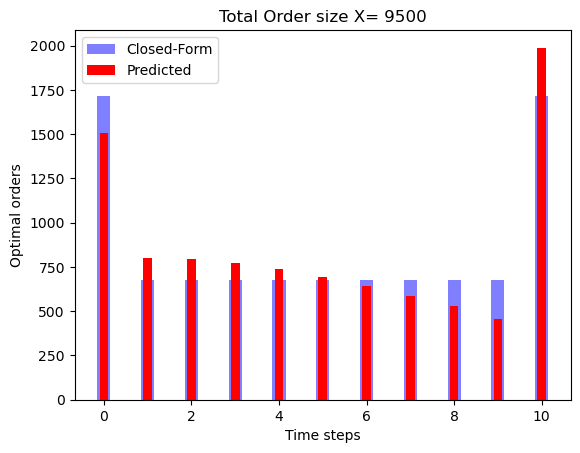

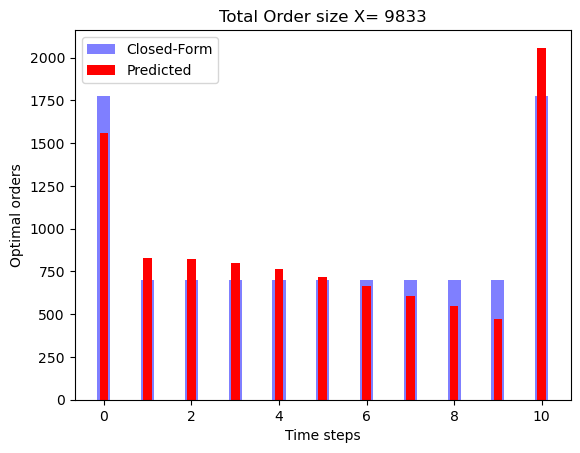

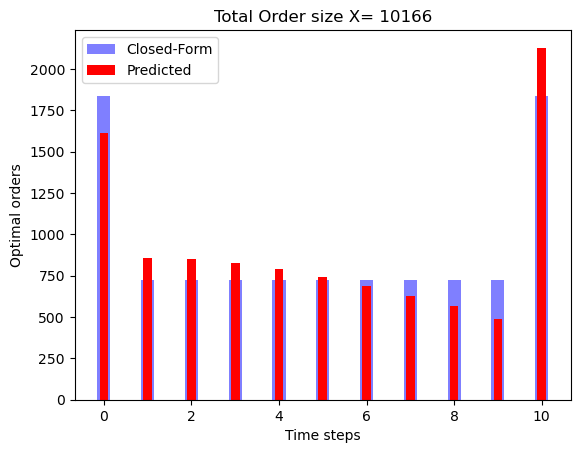

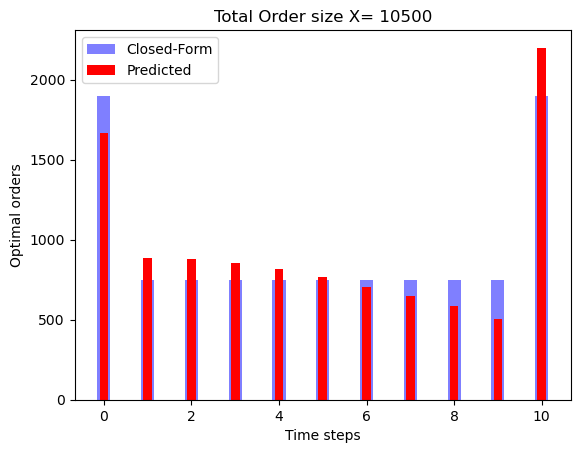

In [ ]:
p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
# name='/Users/shirinprovat/Desktop/Robin_Research/LOB_Linear/N_10_Linear.eps'
def plotting(t):
  #print('Total order size=',x1[t],np.sum(n_soln[t]),np.sum(p_soln[t]))
  #print(n_soln[t],p_soln[t])
  #plt.figure(figsize=(4,3))
  plt.bar(t_step,t_soln[t],color='blue',width=0.3,label='Closed-Form',alpha=0.5)
  plt.bar(t_step,p_soln[t],color='red',width=0.2,label='Predicted')
  #plt.bar(t_step,n_soln[t],color='green',width=0.1,label='numeric')
  plt.title('Total Order size X= %i' % (x1[t]))
  plt.xlabel('Time steps')
  plt.ylabel('Optimal orders')
  plt.legend()

  #plt.savefig('f.eps', format='eps')
#   if(t==0):
#     plt.savefig(name,format='eps')      
  plt.show()
for i in range(0,M1,3):
  plotting(i)


In [ ]:
#torch.save(model, 'model_N10_T1_K1_rho5_neo20.pth') 
#model_coarse = torch.load('model_N10.pth')

In [ ]:
# import json
# cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'kappa':kappa,'Rho':rho,'Total_balance':X0,
#         'Num_neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#           'accuracy':0.005*1/100,'Training_cost':cost_numpy_list}

# file_path=  'N10_T1_rho5_linear_dic.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)

Comparing solution at different time steps

In [ ]:
# #p_soln=a.numpy()
# t_step=np.linspace(0,ite,num=ite+1)
# X=R_test.squeeze(1).numpy()
# def plotting_time(t):
#   #print(t_soln[t],p_soln[t])
#   plt.figure(figsize=(4,3))
#   plt.plot(X,t_soln[:,0],color='blue',label='true')
#   plt.plot(X,p_soln[:,0],color='red',label='pred')
#   # plt.plot(X,n_soln[:,0],color='green',label='numeric')
#   plt.title('At time= %d' % (t_step[t]))
#   plt.xlabel('Total Order size')
#   plt.ylabel('Optimal orders')
#   plt.legend()
#   plt.show
# for i in range(0,t_step.shape[0],5):
#   plotting_time(i)


Absolute sum of the difference between true solution, predicted solution and true soln, numeric soln at each time step

In [ ]:
# sq_error=np.zeros(M1)
# sq_error_num=np.zeros(M1)

# for i in range(M1):
#   sq_error[i]=np.sum(np.abs(t_soln[i]-p_soln[i]))
#   sq_error_num[i]=np.sum(np.abs(t_soln[i]-n_soln[i]))
#   print(np.sum(t_soln[i]),'    ',sq_error[i])

# plt.figure(figsize=(4,2))
# plt.plot(X,sq_error,color='blue',label='pred')
# #plt.plot(X,sq_error_num,color='green',label='numeric')
# plt.title('Error with sample size= %d' % (M1))
# plt.xlabel('Total Order size')
# plt.ylabel('Sum of execution error')
# plt.legend()

Additional rough test

In [ ]:
# from torch.nn.modules.pooling import MaxPool1d
# M1=100
# t_test=torch.zeros([M1,1])
# D_test=torch.zeros([M1,1])
# #D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
# R_test=torch.linspace(50,100,100).unsqueeze(1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
# x_test=torch.cat((t_test,D_test,R_test),dim=1)
# #print('Input=',x_test,'\n')
# soln=[]
# x_update = x_test
# #print(x_update)
# for i in range(ite+1):
#     #print(x_update)
#     soln_pred=model(x_update)
#     #print(soln_pred)
#     x_udpate=update(x_update,soln_pred.squeeze(1))
#     #print(x_update)
#     soln.append(soln_pred)
# strategy = torch.cat(soln,dim=1)
# print(strategy)
# # print('predicted soln=',strategy,'sum of all execution=',torch.sum(strategy,dim=1),'\n')
# a=[]
# b=[]
# c=[]
# for x in R_test:
#     a.append(x.numpy()[0])
#     y=closed_form(x.numpy()[0],ite+1)
#     #print(y)
#     b.append(y[0][0])
#     c.append(y[1])

In [ ]:
#model= torch.load('model_N10.pth')



In [ ]:
# from torch.nn.modules.pooling #model= torch.load('model_N10.pth')import MaxPool1d
# M1=20
# t_test=torch.zeros([M1,1])
# D_test=torch.zeros([M1,1])
# #D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
# #R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
# R_test=torch.linspace(X0*0.95, X0*1.05, steps=M1).unsqueeze(1)
# x_test=torch.cat((t_test,D_test,R_test),dim=1)
# #print('Input=',x_test,'\n')
# a=torch.zeros(M1,ite+1)
# #print(a.shape)
# for i in range(ite+1):
#   if(i!=ite):
#     #print(x_test)
#     soln_pred=model(x_test).squeeze(1).detach()
#     a[:,i]=soln_pred
#     x_test=update(x_test,soln_pred)
#     #print(x_test,'\n')
#   else:
#     a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

# x1=R_test.squeeze().numpy()
# c_true=np.zeros(M1)
# c_pred=np.zeros(M1)
# c_num=np.zeros(M1)
# n_soln=np.zeros((M1,ite+1))
# t_soln=np.zeros((M1,ite+1))

# for i in range(M1):
#   print('size of total order=',x1[i])

#   t_soln[i,:]=closed_form(x1[i])
#   print('closed form soln=',t_soln[i,:],'sum of all execution=',np.sum(t_soln[i,:]))
#   true_cost=cost(t_soln[i,:])
#   c_true[i]=true_cost
#   print('Closed form cost=',true_cost,'\n')

#   print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
#   pred_cost=cost(a[i,:].detach().numpy())
#   print('predicted cost=',pred_cost,'\n')
#   c_pred[i]=pred_cost
#   print('Percent Error in cost=',np.abs(100*(true_cost-pred_cost)/true_cost),'%\n')
    
